In [1]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=66e36e236b8474efcf1151716614e73d4c9abbccd8d5263eec72a755e9bbe581
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=514d29a34469ac39bba87139fd5b65cd19923de05501fa3aed5f6f398a386cc5
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import umap
from sklearn.preprocessing import StandardScaler


# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [4]:
SAVE = True
SAVE_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219")

# データ読み込み

In [5]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

test.head()

,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,beach_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,306.701050,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,1421.016357,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,984.422791,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23
3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,29.648212,...,0.484109,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11
4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,372.873108,...,0.440959,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01


# UMAPで次元削減

## 被度文献データ

In [6]:
cols_umap = [
    "lat",
    "lon",
    "area",
    "year",
    # "month",
    "depth_original",
    "depth",
]

# とりあえず学習データだけでやる
df_umap = train[cols_umap]
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             14140 non-null  float32
 1   lon             14140 non-null  float32
 2   area            14140 non-null  float32
 3   year            14140 non-null  float32
 4   depth_original  4419 non-null   float32
 5   depth           13849 non-null  float32
dtypes: float32(6)
memory usage: 331.5 KB


In [7]:
# 欠損値を埋める
for col in cols_umap:
    df_umap[col] = df_umap[col].fillna(0)

df_umap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             14140 non-null  float32
 1   lon             14140 non-null  float32
 2   area            14140 non-null  float32
 3   year            14140 non-null  float32
 4   depth_original  14140 non-null  float32
 5   depth           14140 non-null  float32
dtypes: float32(6)
memory usage: 331.5 KB


In [8]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [9]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
model = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    # metric='euclidean',
)

embedding = model.fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,9.724916,5.314995
1,-4.535916,-2.649351
2,7.037045,13.504218
3,-9.374556,5.461256
4,-7.200759,9.330148
...,...,...
14135,18.483818,-6.636403
14136,-5.533077,-6.052789
14137,15.434330,-5.467328
14138,-10.642429,-7.880723


In [16]:
if SAVE:
    df_umap["umap_basic_dim0"] = df_embedded["dim0"]
    df_umap["umap_basic_dim1"] = df_embedded["dim1"]
    df_umap.to_csv(SAVE_DIR / "20230403_train_umap_basic.csv", index=False)

In [11]:
# テストデータ
df_umap_test = test[cols_umap]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             4039 non-null   float64
 1   lon             4039 non-null   float64
 2   area            4037 non-null   float64
 3   year            4039 non-null   float64
 4   depth_original  1986 non-null   float64
 5   depth           4017 non-null   float64
dtypes: float64(6)
memory usage: 189.5 KB


In [12]:
# 欠損値を埋める
for col in cols_umap:
    df_umap_test[col] = df_umap_test[col].fillna(0)

df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lat             4039 non-null   float64
 1   lon             4039 non-null   float64
 2   area            4039 non-null   float64
 3   year            4039 non-null   float64
 4   depth_original  4039 non-null   float64
 5   depth           4039 non-null   float64
dtypes: float64(6)
memory usage: 189.5 KB


In [13]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,18.324711,5.876045
1,15.141763,1.962178
2,-8.641450,5.661853
3,10.061807,13.467985
4,19.046165,-11.031809


In [17]:
if SAVE:
    df_umap_test["umap_basic_dim0"] = df_embedded_test["dim0"]
    df_umap_test["umap_basic_dim1"] = df_embedded_test["dim1"]
    df_umap_test.to_csv(SAVE_DIR / "20230403_test_umap_basic.csv", index=False)

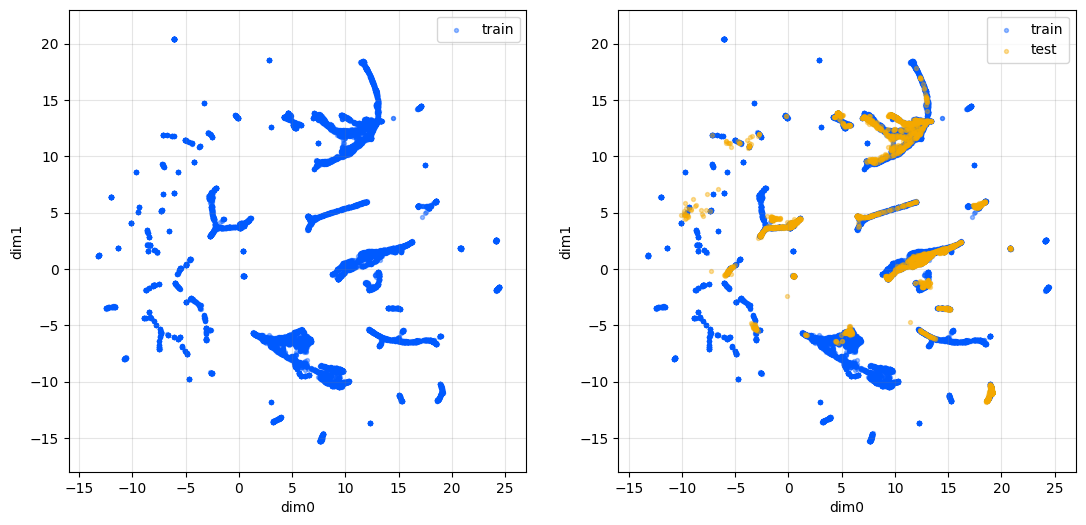

In [15]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

## 海洋環境要因データ

In [ ]:
cols_umap = [
    "cliff_length",
    "aicial_length",
    "beach_length",
    "coast_length",
    "coastal_dist",
    "fetch",
    "cold_sst",
    "hist_cold_sst",
    "warm_sst",
    "hist_warm_sst",
    "sst_annual",
    "sst_ymd",
    "sst_diff",
    "river_area",
    "river_dist",
    "Salinity_annual",
]

# とりあえず学習データだけでやる
df_umap = train[cols_umap]
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     13849 non-null  float32
 1   aicial_length    13849 non-null  float32
 2   beach_length     13849 non-null  float32
 3   coast_length     13849 non-null  float32
 4   coastal_dist     13849 non-null  float32
 5   fetch            13849 non-null  float32
 6   cold_sst         13849 non-null  float32
 7   hist_cold_sst    13849 non-null  float32
 8   warm_sst         13849 non-null  float32
 9   hist_warm_sst    13849 non-null  float32
 10  sst_annual       14140 non-null  float32
 11  sst_ymd          14060 non-null  float32
 12  sst_diff         14060 non-null  float32
 13  river_area       13849 non-null  float32
 14  river_dist       13849 non-null  float32
 15  Salinity_annual  13849 non-null  float32
dtypes: float32(16)
memory usage: 883.9 KB


In [ ]:
# 欠損値を埋める
for col in cols_umap:
    df_umap[col] = df_umap[col].fillna(0)

df_umap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     14140 non-null  float32
 1   aicial_length    14140 non-null  float32
 2   beach_length     14140 non-null  float32
 3   coast_length     14140 non-null  float32
 4   coastal_dist     14140 non-null  float32
 5   fetch            14140 non-null  float32
 6   cold_sst         14140 non-null  float32
 7   hist_cold_sst    14140 non-null  float32
 8   warm_sst         14140 non-null  float32
 9   hist_warm_sst    14140 non-null  float32
 10  sst_annual       14140 non-null  float32
 11  sst_ymd          14140 non-null  float32
 12  sst_diff         14140 non-null  float32
 13  river_area       14140 non-null  float32
 14  river_dist       14140 non-null  float32
 15  Salinity_annual  14140 non-null  float32
dtypes: float32(16)
memory usage: 883.9 KB


In [ ]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [ ]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
embedding = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    # metric='euclidean',
).fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,23.809704,-5.159449
1,2.871492,10.769815
2,7.945698,7.404776
3,16.373024,3.285066
4,7.985211,1.776023
...,...,...
14135,10.533599,4.225242
14136,2.680203,8.793930
14137,9.837677,9.948975
14138,7.289409,2.145755


In [ ]:
# テストデータ
df_umap_test = test[cols_umap]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     4017 non-null   float64
 1   aicial_length    4017 non-null   float64
 2   beach_length     4017 non-null   float64
 3   coast_length     4017 non-null   float64
 4   coastal_dist     4017 non-null   float64
 5   fetch            4017 non-null   float64
 6   cold_sst         4017 non-null   float64
 7   hist_cold_sst    4017 non-null   float64
 8   warm_sst         4017 non-null   float64
 9   hist_warm_sst    4017 non-null   float64
 10  sst_annual       4039 non-null   float64
 11  sst_ymd          4039 non-null   float64
 12  sst_diff         4039 non-null   float64
 13  river_area       4017 non-null   float64
 14  river_dist       4017 non-null   float64
 15  Salinity_annual  4017 non-null   float64
dtypes: float64(16)
memory usage: 505.0 KB


In [ ]:
# 欠損値を埋める
for col in cols_umap:
    df_umap_test[col] = df_umap_test[col].fillna(0)

df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cliff_length     4039 non-null   float64
 1   aicial_length    4039 non-null   float64
 2   beach_length     4039 non-null   float64
 3   coast_length     4039 non-null   float64
 4   coastal_dist     4039 non-null   float64
 5   fetch            4039 non-null   float64
 6   cold_sst         4039 non-null   float64
 7   hist_cold_sst    4039 non-null   float64
 8   warm_sst         4039 non-null   float64
 9   hist_warm_sst    4039 non-null   float64
 10  sst_annual       4039 non-null   float64
 11  sst_ymd          4039 non-null   float64
 12  sst_diff         4039 non-null   float64
 13  river_area       4039 non-null   float64
 14  river_dist       4039 non-null   float64
 15  Salinity_annual  4039 non-null   float64
dtypes: float64(16)
memory usage: 505.0 KB


In [ ]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,10.959320,-8.696629
1,10.778499,15.041822
2,21.256157,-0.332628
3,-4.743186,12.428205
4,-3.354149,15.271708


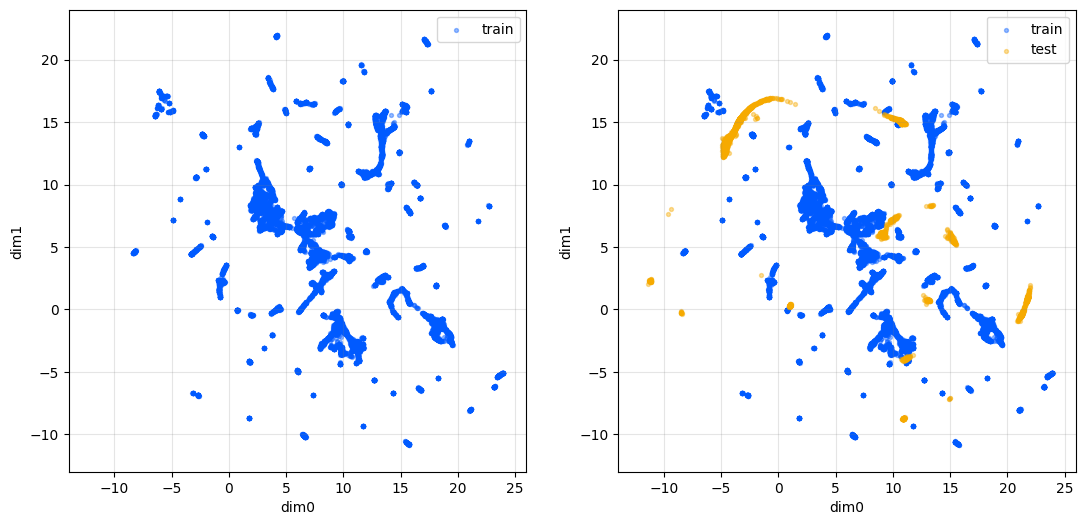

In [ ]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

## 被度文献＋海洋環境要因